# ایمپورت ماژول های مورد استفاده

In [247]:
from sklearn.cluster import KMeans #برای تست دقت الگوریتم
from sklearn.datasets import make_blobs #برای ساختن دیتایی که قابل کلاستر باشه
from sklearn.metrics import classification_report #درصورتی که کانفیوژن متریکس ایدنتیتی باشه
import matplotlib.pyplot as plt #ساخت ریپورت و گراف
import numpy as np
import seaborn as sb #برای زیبایی بیشتر!

# ساخت دیتا

In [248]:
dataX,dataY,dataCenter=make_blobs(n_samples=200,#تعداد دیتا پویتنت ها
                                  n_features=2,#تعداد کالوم های دیتا
                                  return_centers=True,
                                  centers=3,#تعداد کلاسترها
                                  random_state=42, #سیید رندوم
                                  cluster_std=3.3 #میزان پراکنده بودن دیتا پویتنت ها
                                 )

In [249]:
dataX[:4],dataY[:4]

(array([[ 10.79693472,   3.53681832],
        [-11.15435647,  11.72656439],
        [ -6.92004154,  -9.84104902],
        [-11.65830552, -11.52474005]]),
 array([1, 0, 2, 2]))

In [250]:
from scipy.stats.mstats_basic import skew
skew(dataX)
#skewness
#بین -+0.5 هستش
#و این یعنی significantlly asymmetric distrobution

masked_array(data=[ 0.33912408, -0.05059344],
             mask=False,
       fill_value=1e+20)

Text(0.5, 1.0, 'RawData')

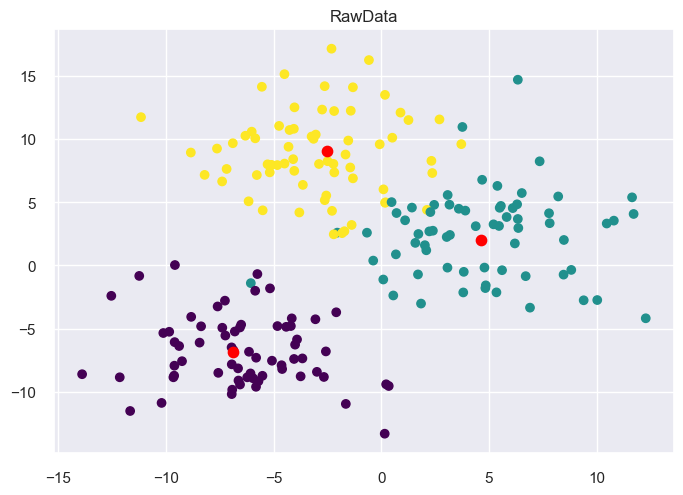

In [251]:
sb.set()
plt.scatter(dataX[:,0],dataX[:,1],c=dataY,cmap="viridis_r")#دیتا
plt.scatter(dataCenter[:,0],dataCenter[:,1],c="red",s=55)#سنترها
plt.title("RawData")

# خوانده شود

برای راحتی خواننده هیچ نرمالیزیشنی انجام نشده

ولی برای گرفتن جواب ریداندنت و جلوگیری از ساختارهای غیر مدنظر در کلاستر حتما و  حتما باید نرمالیزیشن انجام شود

# ساخت مدل برای آزمایش و مقایسه

In [328]:
kk=KMeans(random_state=106,n_clusters=3,init="k-means++",max_iter=100,verbose=1,algorithm="lloyd")
kk.fit(dataX)

Initialization complete
Iteration 0, inertia 10492.283905658525.
Iteration 1, inertia 3784.5494867963953.
Iteration 2, inertia 3747.610639847649.
Iteration 3, inertia 3740.823922855839.
Iteration 4, inertia 3739.3252485823095.
Converged at iteration 4: strict convergence.


KMeans(max_iter=100, n_clusters=3, random_state=106, verbose=1)

Text(0.5, 1.0, 'Sklearn Prediction')

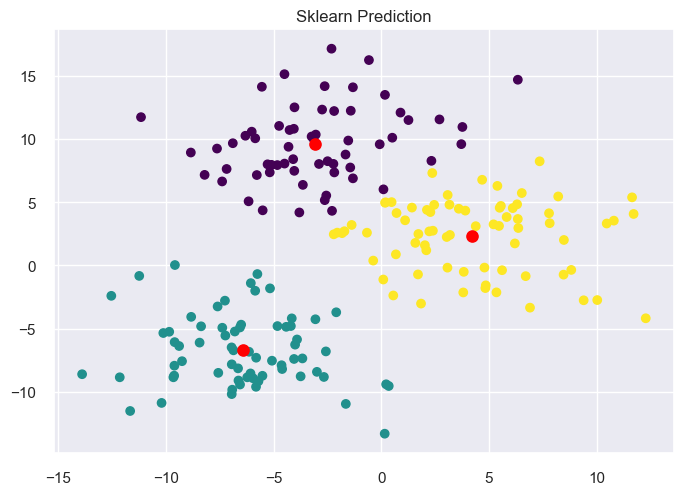

In [276]:
plt.scatter(dataX[:,0],dataX[:,1],c=kk.labels_,cmap="viridis_r")
plt.scatter(kk.cluster_centers_[:,0],kk.cluster_centers_[:,1],c="Red",s=65)
plt.title("Sklearn Prediction")

# نوشتن الگوریتم

In [386]:
import numpy as np
from scipy.spatial import distance #برای محاسبه فاصله بین سنتر و دیتاپوینت
import random
#random.seed(42)

class KMeansAlgorithms:
    def __init__(self, k=3, max_iterations=100, use_elkan=False, use_lloyd=True):
        self.k = k #تعداد کلاسترها
        self.max_iterations = max_iterations #دفعات انجام کد
        self.use_elkan = use_elkan #این الگوریتم محاسبات زمانبری رو انجام میده وبرای دیتاهای بزرگ اصلا مناسب نیست
        self.use_lloyd = use_lloyd #الگوریتم پیشنهادی
        
    # Initialize centroids using KMeans++
    def initialize_centroids(self, X): #Kmeans++
        centroids = [] #لیست سنترها
        centroid_idx = random.choice(range(X.shape[0])) #گرفتن تعداد دیتاها و انتخاب یک دیتاپوینت رندم
        centroids.append(X[centroid_idx]) #اضاف کردن دیتاپوینت به لیست سنتر ها
        
        distances = np.zeros((X.shape[0],)) #ساختن یک وکتور برای گرفتن فاصله دیتاپوینت با سنتر
        remaining_points = set(range(X.shape[0]))
        
        for _ in range(self.k - 1):
            for idx in remaining_points:
                distances[idx] = min([distance.euclidean(X[idx], c) for c in centroids])
            '''
            اینجا یک لوپ تعداد کلاستر و لوپ دیتاهای باقی مانده درست می کنیم
            و هر دیتاپوینت رو با سنتر رندم با استفاده از فاصله فیثاغورسی پیدا میکنیم
            '''
            probabilities = distances / sum(distances) #برای گرفتن عددی بین 0 تا 1 که احتمال هستش باید دیتا رو نرمال کنیم
            next_centroid_idx = np.random.choice(range(X.shape[0]), p=probabilities) #سنتر بعدی رو انتخاب میکنیم
            centroids.append(X[next_centroid_idx]) #این سنتر رو از به لیست سنتر اضاف میکنیم
            remaining_points.remove(next_centroid_idx)#سنتر انتخابی رو باید از دیتا حذف کنیم
            """
            این کارو به انقدر انجام میدیم که بهترین سنتر پیدا بشه
            """
        return np.array(centroids)
    
    # Assign each point to its closest cluster center
    def assign_clusters(self, X, centroids):#بهترین سنتر رو پیدا میکنیم
        clusters = np.zeros((X.shape[0],), dtype=np.int32)
        
        for i in range(len(X)):
            closest_centroid_index = np.argmin([distance.euclidean(X[i], c) for c in centroids])
            clusters[i] = closest_centroid_index
        
        return clusters
     
    # Update centroids based on assigned clusters
    def update_centroids(self, X, clusters):# سنتر رو به کلاستر اضاف میکنیم
        updated_centroids = np.zeros((self.k, X.shape[1]))
        counts = np.zeros((self.k, ))
        # این همون الگوریتم lloyd 
        #هستش
        for idx, label in enumerate(clusters):
            updated_centroids[label] += X[idx]
            counts[label] += 1
            
        for i in range(updated_centroids.shape[0]):
            updated_centroids[i] /= counts[i]
        
        return updated_centroids
      
    # --->Elkan algorithm<---
    def update_centroids_elkan(self, X, clusters, old_centroids):
        updated_centroids = np.copy(old_centroids)
        changes = False
        """
        این الگوریتم اصلا برای دیتاهای زیاد مناسب نیست و باعث هدر رفتن منابع میشه
        به طور کلی هم دقتی که بقیه الگوریتم ها دارن رو نداره
        میشه گفت که یه الگوریتم منسوخ شده است
        """
        for j in range(self.k):
            neighbor_list = list(set(range(X.shape[0])) - set(clusters[clusters != j]))
            
            squared_distances = np.zeros((len(neighbor_list)))
            
            for i, neighbor in enumerate(neighbor_list):
                """
                محاسبات الکان بسیار محاسبه پیچیده ای هستش و اینجا اصلا جای مناسبی برای نشان دادن این محاسبات نیست
                ولی خب:
                فاصله فیثاغورسی رو پیدا میکنیم
                به توان دو میرسونیم
                بیشترین و کمترین یا با اختصار اکستریما رو پیدا میکنیم
                این روند رو تکرار میکنیم تا بهترین فاصله از دیتا پوینت رو پیدا کنیم
                و سنتررو اپدیت میکنیم
                و دوباره روند رو تکرار میکنیم
                """
                sqr_dist = distance.squareform(distance.pdist([X[neighbor], updated_centroids[j]], 'euclidean'))
                lowerbound = max([sqr_dist[0][1] + sqr_dist[1][0] - distance.squareform(distance.pdist(old_centroids[[j]]))[0][0]])
                upperbound = sqr_dist[0][0]
                bounds = (lowerbound <= upperbound) | ((upperbound - lowerbound) < 1e-10)
                squared_distances[i] = upperbound if bounds else float('inf')
             
            if len(squared_distances) > 0:
                min_index = np.argmin(squared_distances)
                updated_centroids[j] = X[neighbor_list[min_index]]
                changes = True
            else:
                updates_needed = True
                while updates_needed:
                    updates_needed = False
                    neighbors = np.where(clusters == j)[0]
                    non_empty_dimensions = np.count_nonzero(~np.isnan(X[neighbors].sum(axis=0)), axis=-1)
                    dimensions_to_drop = np.argsort(non_empty_dimensions)[::-1][self.k:]
                    if len(dimensions_to_drop) > 0:
                        drop_indices = np.ix_(dimensions_to_drop, range(X.shape[1]))
                        dropped_data = np.delete(X[neighbors], dimensions_to_drop, axis=1)
                        mean_dropped_data = np.mean(dropped_data, axis=0)
                        indices = np.arange(len(neighbors)).reshape(-1, 1)[:, np.newaxis]
                        means = np.repeat(mean_dropped_data[np.newaxis, :], repeats=len(neighbors), axis=0)
                        differences = X[neighbors][indices, drop_indices] - means[indices, drop_indices]
                        squares = np.power(differences, 2)
                        variances = np.sum(squares, axis=1)/(len(neighbors)-1)
                        threshold = np.percentile(variances, 100-(100/(len(neighbors)+1)))
                        selected_dimensions = np.where(variances > threshold)[0]
                        selected_dimensions = np.concatenate([selected_dimensions, dimensions_to_drop]).tolist()
                        X[neighbors] = X[neighbors][..., selected_dimensions]
                        updated_centroids[j] = np.mean(X[neighbors], axis=0)
                        if len(selected_dimensions) < X.shape[1]:
                            updates_needed = True
                            changes = True
                        elif np.linalg.norm(updated_centroids[j] - old_centroids[j]) > 1e-10:#این تالرنس هستش
                            changes = True
                        else:
                            break
        
        return updated_centroids if changes else old_centroids

    # --->Fitting Function<---
    def fit(self, X):
        centroids = self.initialize_centroids(X)
        previous_centroids = None
        iteration = 0

        if self.use_elkan:
            fitting_func = self._fit_elkan
        elif self.use_lloyd:
            fitting_func = self._fit_lloyd
        else:
            raise ValueError("Please select valid fitting method.")

        while True:
            iteration += 1 #تعداد انجام کار
            clusters = self.assign_clusters(X, centroids)
            old_centroids = centroids
            centroids = fitting_func(X, clusters, old_centroids)
            
            if np.allclose(old_centroids, centroids):
                break
            
            if iteration >= self.max_iterations:
                break
          
        return centroids, clusters

    def _fit_elkan(self, X, clusters, old_centroids):
        centroids = self.update_centroids_elkan(X, clusters, old_centroids)
        return centroids

    def _fit_lloyd(self, X, clusters, old_centroids):
        centroids = self.update_centroids(X, clusters)
        return centroids

# Usage Example
    """kmeans = KMeansAlgorithms(k=3, max_iterations=100, use_elkan=True, use_lloyd=False)
    centroids, clusters = kmeans.fit(X)
    print("Centroids:", centroids)
    print("Clusters:", clusters)
    kmeans = KMeansAlgorithms(k=3, max_iterations=100, use_elkan=False, use_lloyd=True)
    centroids, clusters = kmeans.fit(X)
    print("Centroids:", centroids)
    print("Clusters:", clusters)"""

In [370]:
kmaCent,kmalabel=KMeansAlgorithms(k=3,max_iterations=100,use_elkan=False,use_lloyd=True).fit(dataX)
kmaCent2,kmalabel2=KMeansAlgorithms(k=3,max_iterations=100,use_elkan=True,use_lloyd=False).fit(dataX)

Text(0.5, 1.0, 'Elkan pred')

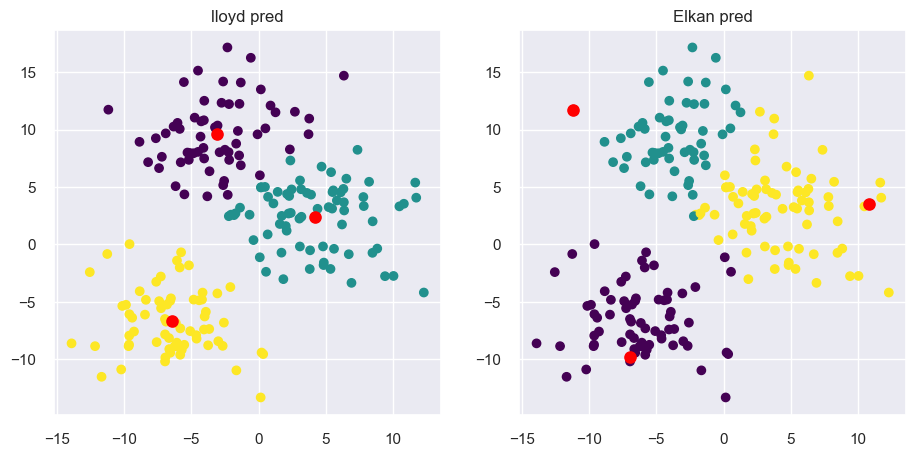

In [341]:
plt.subplots(1,2,figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(dataX[:,0],dataX[:,1],c=kmalabel,cmap="viridis_r")
plt.scatter(kmaCent[:,0],kmaCent[:,1],c="Red",s=65)
plt.title("lloyd pred")
plt.subplot(1,2,2)
plt.scatter(dataX[:,0],dataX[:,1],c=kmalabel2,cmap="viridis_r")
plt.scatter(kmaCent2[:,0],kmaCent2[:,1],c="Red",s=65)
plt.title("Elkan pred")

# ممکنه کلاسترها جابه جا ساین بشن ولی درهر صورت درستن

مثلا کلاستر0 رو 1 انتخاب کنه یا کلاستر 1 رو 2 


بخاطر همین از کانفیوژن ماتریکس باید استفاده بشه

In [371]:
#KMeans Sklearn
confusion_matrix(dataY,kk.labels_)
#تعداد اشتباهات 11

array([[59,  8,  0],
       [ 2, 64,  1],
       [ 0,  0, 66]], dtype=int64)

In [372]:
#made-up kmeans elkan algo
confusion_matrix(dataY,kmalabel2)
#تعداد اشتباهات 14

array([[11, 56,  0],
       [64,  0,  3],
       [ 0,  0, 66]], dtype=int64)

In [373]:
#made-up kmeans lloyd algo
confusion_matrix(dataY,kmalabel)
#تعداد اشتباهات 6

array([[ 0,  1, 66],
       [ 1, 62,  4],
       [66,  0,  0]], dtype=int64)

In [375]:
print(f"Statistics for Sklearn:\n{classification_report(dataY,kk.labels_)}\n")

Statistics for Sklearn:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        67
           1       0.89      0.96      0.92        67
           2       0.99      1.00      0.99        66

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.94      0.94       200




# چطور sklearn دقت کمتری داشت؟

In [207]:
#1)الگوریتم نوشته شده بهتربود!!
#2) ---->hypermarameters<-----

In [206]:
from sklearn.model_selection import GridSearchCV

In [376]:
kk_params={"init":["k-means++","random"],#2 حالت
           "copy_x":[True,False],#2 حالت
           "tol":[1e-5,1e-4,1e-3,1e-2,1e-2,0.1],#6 حالت
           "algorithm":["lloyd","elkan"],#2 حالت
          "max_iter":[50,100,200,300]#4حالت 
          }
kkgrd=GridSearchCV(estimator=KMeans(n_clusters=3,random_state=42),param_grid=kk_params)
kkgrd.fit(dataX)

GridSearchCV(estimator=KMeans(n_clusters=3, random_state=42),
             param_grid={'algorithm': ['lloyd', 'elkan'],
                         'copy_x': [True, False],
                         'init': ['k-means++', 'random'],
                         'max_iter': [50, 100, 200, 300],
                         'tol': [1e-05, 0.0001, 0.001, 0.01, 0.01, 0.1]})

In [377]:
kkgrd.best_params_

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'random',
 'max_iter': 50,
 'tol': 0.1}

In [378]:
confusion_matrix(dataY,KMeans(n_clusters=3,max_iter=50,copy_x=True,init="random",
                              tol=0.1,algorithm="lloyd",random_state=42).fit_predict(dataX))
#11 اشتباه

array([[59,  0,  8],
       [ 2,  1, 64],
       [ 0, 66,  0]], dtype=int64)

In [385]:
#madeup-lloyd:6
#sklearn-lloyd:11

In [433]:
import time
start=time.perf_counter_ns()
kk=KMeans(random_state=106,n_clusters=3,init="k-means++",max_iter=100,algorithm="lloyd")
print(f"{time.perf_counter_ns()-start:,} ns")

158,000 ns


In [434]:
start=time.perf_counter_ns()
kk2=KMeansAlgorithms(k=3,max_iterations=100,use_elkan=False,use_lloyd=True)
print(f"{time.perf_counter_ns()-start:,} ns")

149,400 ns


In [430]:
#تقریبا هر دو سرعت یکسانی دارن